# Colorization demo
In this notebook we presents how our model can be used to colorize any portraits.

In [1]:
from keras.layers import Input, Reshape, Dropout, BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, concatenate
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model, save_model
from matplotlib.colors import LinearSegmentedColormap
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
import csv, os
from PIL import Image as PImage
from IPython.display import clear_output
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# loads the last model with the given name
# saved models should follow the naming method of 'CheckPointer'
# net_name: name of the net
def loadLastModel(net_name):
    net_name = net_name.upper() # using uppercases, so net_name is not case sensitive
    # list of previous saved networks
    previous_nets = [x for x in os.listdir('weights/' + net_name + '/') if net_name in x]
    if len(previous_nets) == 0: # if there were no previous
        # print some feedback
        print('ERROR: There is no previous models with this name:', net_name)
    else: # if we have at least one previous model
        # print some feedback
        print('Loading model:', previous_nets[-1])
        # return with the loaded model
        # path: 'weights/NETNAME/NETNAME_XX.hdf5'
        return load_model('weights/' + net_name + '/' + previous_nets[-1])
    
# upscales our normalized image
# funtcion of min-max scaling: y = (x-min(x))/(max(x)-min(x))
# so the reversed is: x = y*(max(x)-min(x)) + min(x)
def outputscaler(img):
    ret = np.zeros(img.shape) # allocate space for return data
    ret[:,:,0] = np.round(img[:,:,0]*100)     # L channel goes from 0 - +100
    ret[:,:,1:3] = np.round((img[:,:,1:3]*255))-128 # A and B channels range is from -128 to +127
    return ret

We wrote two different method to colorize any size of pictures:
* v1: reshape picture to 128x128 with distortion, than predict colors and reshape color channels to original size and finally use the original L channel so the picture will be sharp

* v2: reshape picture to fit in 128*128 and keep aspect ratio, than predict colors and upscale and crop color channels and finally use the original L channel so the picture will be sharp

In [3]:
# colorize image, method v1
def color_imgv1(image, model):
    original = np.array(image) # convert image to numpy array
    
    # resize to 128x128
    img = cv2.resize(original, dsize = (128,128), interpolation = cv2.INTER_AREA)
    
    # if picture has more channels convert it to only one grayscale
    if len(img.shape) == 2: # it's a grayscale image
        original = np.atleast_3d(original/255)
        img = np.atleast_3d(img/255) # normalize image
    else: #it's rgb image with 3 channels
        original = np.atleast_3d(rgb2gray(original))
        img = np.atleast_3d(rgb2gray(img)) # convert to grayscale, it will be normalized automaticaly
        
    img.shape = (1,) + img.shape # adding 4th dimension
    preds = model.predict(img)[0] # predict color
    
    # upscale and adding L channel
    if preds.shape[2] == 2: # only A and B channels was generated
        preds = cv2.resize(preds, dsize = (original.shape[1], original.shape[0]),
                           interpolation = cv2.INTER_AREA) # upscale A and B channels
        preds = np.concatenate((original,preds),axis = 2) # adding L channel
    elif preds.shape[2] == 3: # all 3 channels was generated
        preds = cv2.resize(preds,  dsize = (original.shape[1], original.shape[0]),
                           interpolation = cv2.INTER_AREA) # upscale A and B channels
        preds[:,:,0:1] = original # adding original L channel
    
    return lab2rgb(outputscaler(preds)), original

In [4]:
# colorize image, method v2
def color_imgv2(image, model, save_dir = None):
    original = np.array(image) # convert image to numpy array
    shape = original.shape
    
    # if picture has more channels convert it to only one grayscale
    if len(shape) == 2: # it's a grayscale image
        original = np.atleast_3d(original/255)
    else: #it's rgb image with 3 channels
        original = np.atleast_3d(rgb2gray(original))
    
    # add padding to reach square shape
    if shape[0] > shape[1]:
        bigger = shape[0]
        image = np.zeros((shape[0],shape[0],1))
        fromX = 0
        toX = shape[0]
        fromY = (shape[0]-shape[1])//2
        toY = (shape[0]-shape[1])//2 + shape[1]
        image[:,fromY:toY] = original
    else:
        bigger = shape[1]
        image = np.zeros((shape[1],shape[1],1))
        fromX = (shape[1]-shape[0])//2
        toX = (shape[1]-shape[0])//2 + shape[0]
        fromY = 0
        toY = shape[1]
        image[fromX:toX,:] = original
    
     # resize to 128x128
    img = cv2.resize(image, dsize = (128,128), interpolation = cv2.INTER_AREA)
    
    img.shape = (1,) + img.shape + (1,) # add 4th dimension
    preds = model.predict(img)[0] # predict color
    
    # upscale,crop and add L channel
    if preds.shape[2] == 2: # only A and B channels was generated
        
        preds = cv2.resize(preds, dsize = (bigger, bigger),
                           interpolation = cv2.INTER_AREA) # upscale A and B channels
        preds = preds[fromX:toX, fromY:toY,:] # crop
        preds = np.concatenate((original,preds),axis = 2) # adding L channel
        
    elif preds.shape[2] == 3: # all 3 channels was generated
        preds = cv2.resize(preds,  dsize = (bigger, bigger),
                           interpolation = cv2.INTER_AREA) # upscale A and B channels
        preds = preds[fromX:toX, fromY:toY,:] # crop
        preds[:,:,0:1] = original # add original L channel
    
    return lab2rgb(outputscaler(preds)), original


# Loading models

In [5]:
# defining new loss function for keras
def SSIMLoss(y_true, y_pred):
    # SSIM gives higher number for better similarity, so we need the opposite of it
    return 1 - tf.image.ssim(y_true, y_pred, 1)
# add loss function to keras
get_custom_objects().update({"SSIMLoss": SSIMLoss})

# loading UNET
unet4 = loadLastModel('unet4')

Loading model: UNET4_73.hdf5


In [6]:
gan2gen = load_model('weights/GAN2/GAN2_35.hdf5').layers[1]

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# Final results
For testing we used portraits of famous scientists. <br/>
As we can see there is no best model or best method. Sometimes UNET gives more real colors, sometimes GAN predicts better. The difference between the two methods is even less.

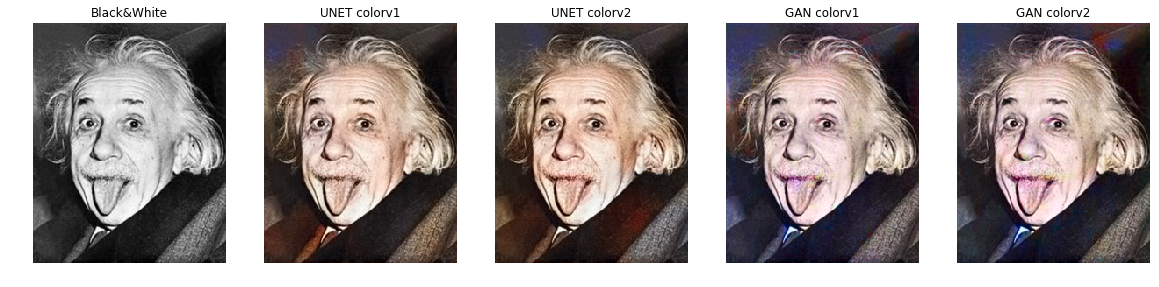

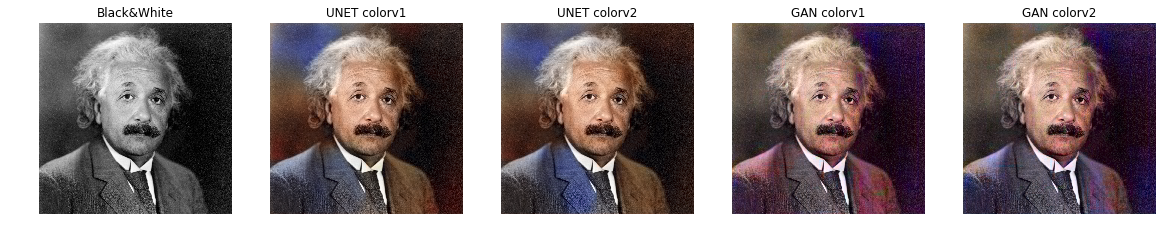

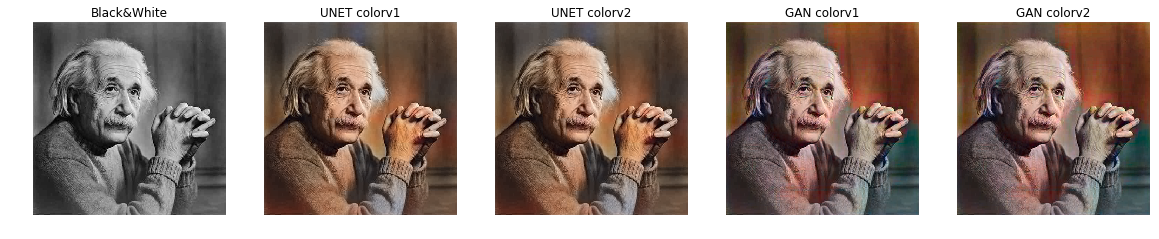

C:\ProgramData\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 18 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


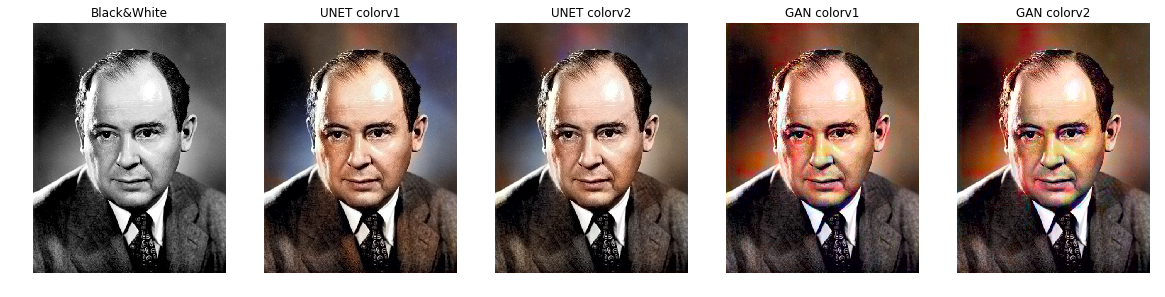

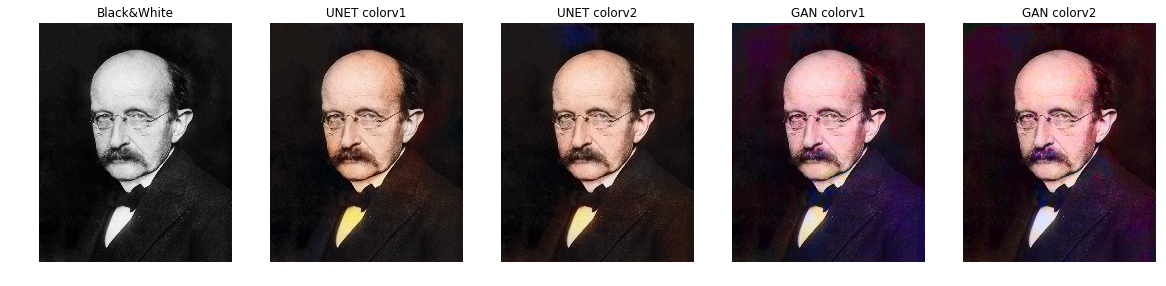

C:\ProgramData\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


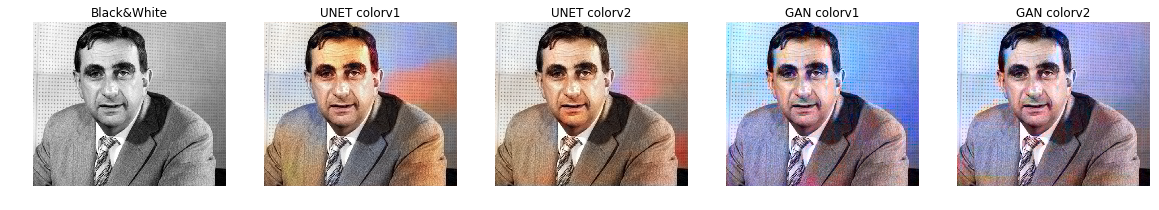

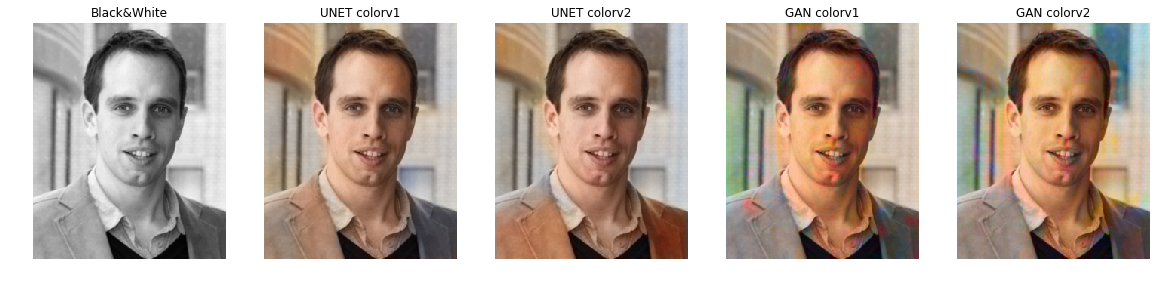

In [9]:
imgs = ['BW/einstein.jpg','BW/einstein2.jpg','BW/einstein3.jpg','BW/tesla.jpg','BW/tesla2.jpg',
        'BW/neumann.jpg','BW/planck.jpg','BW/teller.jpg','BW/teller2.jpg','BW/balint.jpg'] # paths of images

for img in imgs: # iterate over images
    f, axarr = plt.subplots(figsize=(20, 10), nrows = 1, ncols = 5)
    
    # black and white
    axarr[0].axis('off')
    axarr[0].imshow(np.squeeze(color_imgv1(PImage.open(img), unet4)[1]),cmap = 'gray')
    axarr[0].set_title('Black&White')

    # unet with v1
    axarr[1].axis('off')
    axarr[1].imshow(color_imgv1(PImage.open(img), unet4)[0])
    axarr[1].set_title('UNET colorv1')

    # unet with v2
    axarr[2].axis('off')
    axarr[2].imshow(color_imgv2(PImage.open(img), unet4)[0])
    axarr[2].set_title('UNET colorv2')

    # gan with v1
    axarr[3].axis('off')
    axarr[3].imshow(color_imgv1(PImage.open(img), gan2gen)[0])
    axarr[3].set_title('GAN colorv1')

    # gan with v2
    axarr[4].axis('off')
    axarr[4].imshow(color_imgv2(PImage.open(img), gan2gen)[0])
    axarr[4].set_title('GAN colorv2')
    plt.show()